In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.plots import display_candidate_loss
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.torch_fwrf import get_value

In [51]:
from imp import reload
import src.torch_fwrf as aaa
reload(aaa)
from src.torch_fwrf import linspace, logspace, model_space, learn_params_ridge_regression, get_predictions

In [3]:
import torch
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [4]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [5]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'frameon': False}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'deepnet-fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
output_dir = root_dir+"output/S%02d/" % subject
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: Mar-26-2020_0201


# Load stimuli

In [6]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [7]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(10000, 3, 227, 227)
uint8
0 255


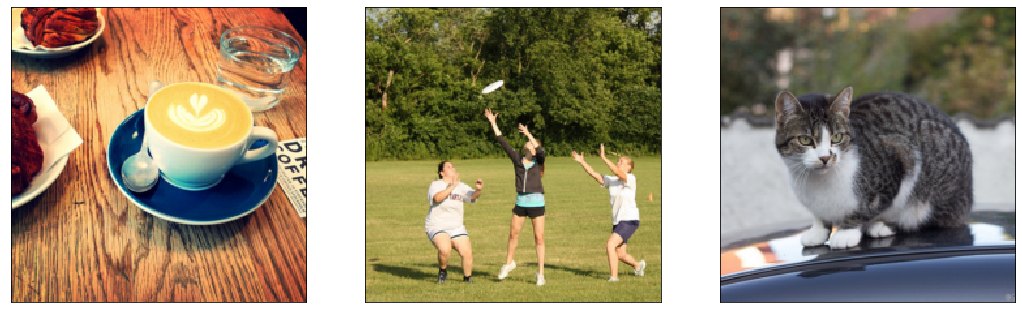

In [8]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [9]:
from src.file_utility import load_mask_from_nii, view_data

In [10]:
voxel_r2_full      = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%(subject))
tight_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%subject)
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
voxel_roi_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))

brain_nii_shape = brain_mask_full.shape

brain_mask_full = tight_mask_full.flatten().astype(bool)
voxel_r2_brain  = voxel_r2_full.flatten()[brain_mask_full]
voxel_idx_brain = np.arange(len(brain_mask_full))[brain_mask_full]
voxel_roi_brain = voxel_roi_full.flatten()[brain_mask_full]

general_mask_full = (general_mask_full==1).flatten().astype(bool)
voxel_r2_general  = voxel_r2_full.flatten()[general_mask_full]
voxel_idx_general = np.arange(len(general_mask_full))[general_mask_full]
voxel_roi_general = voxel_roi_full.flatten()[general_mask_full]

## Display a slice of the data

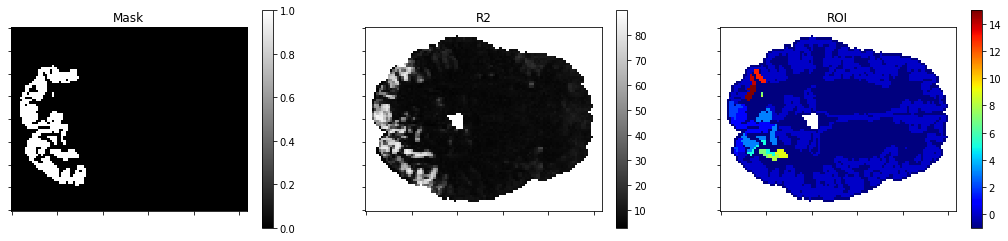

In [11]:
volume_r2         = view_data(voxel_r2_full.shape, voxel_idx_brain, np.nan_to_num(voxel_r2_brain))
volume_brain_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), general_mask_full)
volume_brain_roi  = view_data(voxel_r2_full.shape, voxel_idx_brain, voxel_roi_brain)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_r2[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('R2')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,3)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [12]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_mask = general_mask_full
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=-1)
print (voxel_data.shape)

/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.066, <sigma> = 0.915
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.927, <sigma> = 0.826
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.163, <sigma> = 0.944
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.886, <sigma> = 0.797
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.007, <sigma> = 0.892
/home/styvesg/repo.data/datasets/ns

In [13]:
voxel_idx = voxel_idx_general
voxel_roi = voxel_roi_general
voxel_r2  = voxel_r2_general

## Voxel grouping and voxel ROI iterator

In [14]:
from src.roi import iterate_roi, roi_map

roi_group_names = ['V1', 'V2', 'V3', 'V4', 'VO', 'PHC', 'MST', 'hMT', 'LO', 'V3a/b', 'IPS', 'All']
roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23], np.arange(1,24)]
for roi_mask, roi_name in iterate_roi(roi_group, voxel_roi, roi_map, group_name=roi_group_names):
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

1982 	: V1
1565 	: V2
1385 	: V3
462 	: V4
519 	: VO
374 	: PHC
54 	: MST
281 	: hMT
517 	: LO
875 	: V3a/b
931 	: IPS
8945 	: All


## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [15]:
data_size, nv = voxel_data.shape 
print ("Total number of voxels = %d" % nv)

ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print ("Validation size =", val_size, ", Training size =", trn_size)

Total number of voxels = 15660
Validation size = 3000 , Training size = 27000


In [16]:
## double and triple check that I haven't misaligned the image and responses.
trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]

stim_data = image_data[ordering_data]  # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_stim_data = stim_data[shared_mask]

# Create model
By arbitrary convention, all variables, ojects or functions that return either of those on the device will begin with an underscore.

In [17]:
from torchvision.models.alexnet import alexnet, load_image_batch

_extractor = alexnet(pretrained=True).to(device)
_fmaps_fn = lambda x: _extractor(load_image_batch(x, device=device))

_fmaps = _fmaps_fn(image_data[:100])
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 1000, 1, 1])


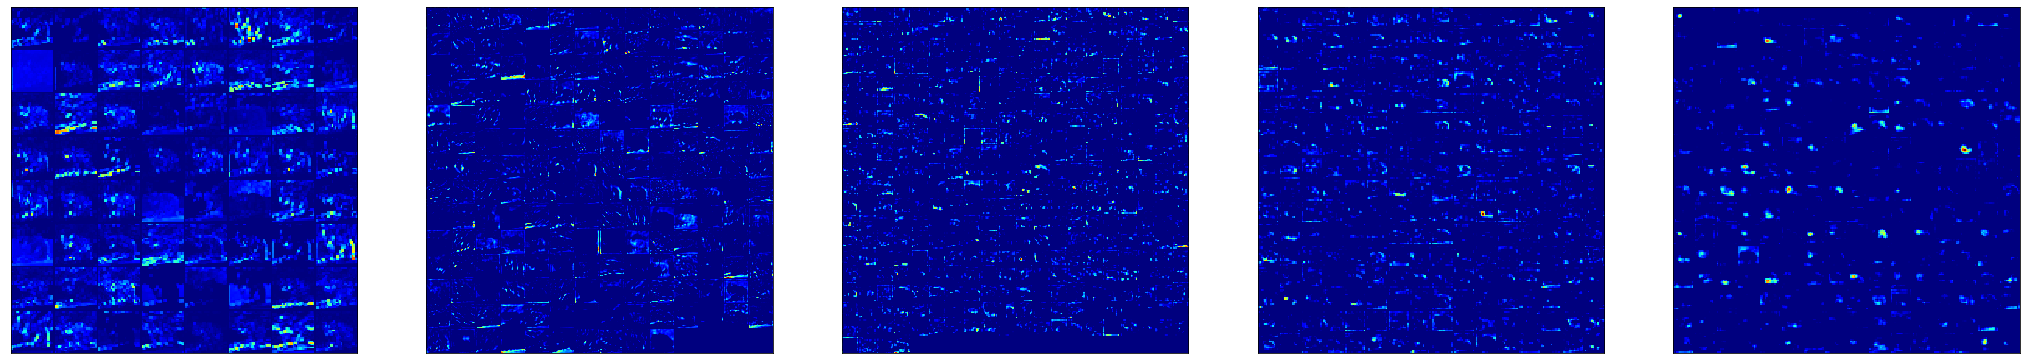

In [18]:
plt.figure(figsize=(36,12))
for k,_fm in enumerate(_fmaps[:5]):
    plt.subplot(1,5,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[8], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [20]:
from src.torch_feature_space import filter_dnn_feature_maps

_fmaps_fn, lmask, fmask, tuning_masks = filter_dnn_feature_maps(image_data, _fmaps_fn, batch_size=100, fmap_max=512)

100it [00:09, 10.79it/s]

layer: 0, shape=(100, 64, 27, 27)
layer: 1, shape=(100, 192, 27, 27)
layer: 2, shape=(100, 384, 13, 13)
layer: 3, shape=(100, 256, 13, 13)
layer: 4, shape=(100, 256, 13, 13)
layer: 5, shape=(100, 512, 1, 1)
layer: 6, shape=(100, 512, 1, 1)
layer: 7, shape=(100, 512, 1, 1)



fmaps: 0, shape=(100, 256, 27, 27)
fmaps: 1, shape=(100, 896, 13, 13)
fmaps: 2, shape=(100, 1536, 1, 1)


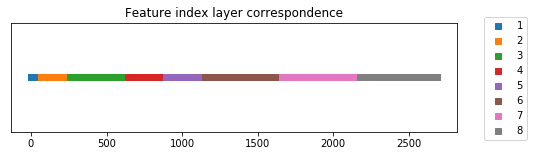

In [21]:
plt.figure(figsize=(8, 2))
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='s', linestyle='None', label=k+1)
_=plt.title('Feature index layer correspondence')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.1))

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

In [ ]:
from src.torch_fwrf import linspace, logspace, model_space, learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
nx = ny = 3
smin, smax = np.float32(0.05), np.float32(0.4)
ns = 3

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
model_specs = [[(0., aperture*1.1), (0., aperture*1.1), (smin, smax)], [linspace(nx), linspace(ny), logspace(ns)]]
models = model_space(model_specs)

sample_batch_size = 200
voxel_batch_size = 300
holdout_size = 1000
lambdas = np.logspace(4.,7.,6, dtype=np.float32)
#_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))*torch.tanh(torch.abs(_x))


best_losses, best_lambdas, best_models, best_params, best_avg, best_std = learn_params_ridge_regression(
    trn_stim_data, trn_voxel_data, _fmaps_fn, models, lambdas, \
    aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)

trn_size = 26000 (96.3%)
dtype = <class 'numpy.float32'>
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model   12 of 27  , voxels [ 15600:15659 ] of 15660

In [ ]:
val_voxel_pred = get_predictions(val_stim_data, _fmaps_fn, best_models, best_params, best_avg, best_std,\
    _nonlinearity=None, aperture=aperture, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size)

In [ ]:
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

In [ ]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.yscale('log')
_=plt.xlim([-.5, 1.0])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

In [ ]:
volume_loss = view_data(voxel_r2_full.shape, voxel_idx, best_losses)
volume_cc   = view_data(voxel_r2_full.shape, voxel_idx, val_cc)
slice_idx = 40
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(volume_loss[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(volume_cc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

In [69]:
#lin_cc = np.copy(val_cc)

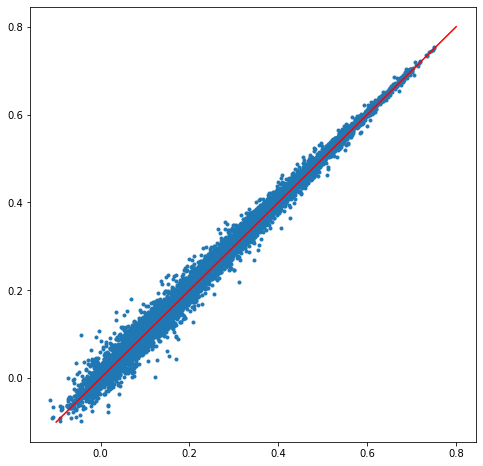

In [70]:
fig=plt.figure(figsize=(8, 8))
plt.plot(lin_cc, val_cc, '.', linestyle='None')
plt.plot([-.1, .8], [-.1, .8], 'r')

# Save results to disk

In [190]:
from imp import reload
import src.file_utility as aaa
reload(aaa)
from src.file_utility import save_stuff, flatten_dict, embed_dict

In [191]:
model_params = {
    'lmask': lmask,
    'fmask': fmask,
    'tuning_masks': tuning_masks,
    'aperture': aperture,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'val_size': val_size,
    'trn_size': trn_size,
    'shared_mask': shared_mask,
    'image_order': ordering_data,
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi,
    'rf_params': models,
    'w_params': best_params,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'normavg': best_avg,
    'normstd': best_std, 
    'val_cc': val_cc,
    }

param_file_name = "dnn_fwrf_%s_params" % (timestamp)
print (param_file_name)

save_stuff(output_dir + param_file_name, flatten_dict(model_params))

dnn_fwrf_Mar-25-2020_2247_params
saved lmask/0 in h5py file
saved lmask/1 in h5py file
saved lmask/2 in h5py file
saved fmask/0 in h5py file
saved fmask/1 in h5py file
saved fmask/2 in h5py file
saved tuning_masks/0 in h5py file
saved tuning_masks/1 in h5py file
saved tuning_masks/2 in h5py file
saved tuning_masks/3 in h5py file
saved tuning_masks/4 in h5py file
saved tuning_masks/5 in h5py file
saved tuning_masks/6 in h5py file
saved tuning_masks/7 in h5py file
saved aperture in h5py file
saved voxel_mask in h5py file
saved brain_nii_shape in h5py file
saved val_size in h5py file
saved trn_size in h5py file
saved shared_mask in h5py file
saved image_order in h5py file
saved voxel_index in h5py file
saved voxel_roi in h5py file
saved rf_params in h5py file
saved w_params/0 in h5py file
saved w_params/1 in h5py file
saved lambdas in h5py file
saved best_lambdas in h5py file
saved normavg in h5py file
saved normstd in h5py file
saved val_cc in h5py file


# Flattening mixture of dictionary and list to save to the efficient h5py format

In [186]:
adict = {
    'list_of_dict': [{'x': 1}, {'y': 2, 'z': 3}],
    'dict_of_list': {'a': [1,2], 'b': [3,4]}
}
fdict = flatten_dict(adict)
edict = embbed_dict(fdict)
print (adict)
print (fdict)
print (edict)

{'list_of_dict': [{'x': 1}, {'y': 2, 'z': 3}], 'dict_of_list': {'a': [1, 2], 'b': [3, 4]}}
{'list_of_dict/0.x': 1, 'list_of_dict/1.y': 2, 'list_of_dict/1.z': 3, 'dict_of_list.a/0': 1, 'dict_of_list.a/1': 2, 'dict_of_list.b/0': 3, 'dict_of_list.b/1': 4}
{'list_of_dict': [{'x': 1}, {'y': 2, 'z': 3}], 'dict_of_list': {'a': [1, 2], 'b': [3, 4]}}


In [ ]:
class Torch_FWRF(L.Module):
    def __init__(self, fmaps, rf_rez=1, nv=1, pre_nl=None, post_nl=None, dtype=np.float32):
        super(Torch_FWRF, self).__init__()
        self.fmaps_shapes = [list(f.size()) for f in fmaps]
        self.nf = np.sum([s[1] for s in self.fmaps_shapes])
        self.pre_nl  = pre_nl
        self.post_nl = post_nl
        self.nv = nv
        self.ns = np.square(rf_rez)

        self.rfs = [L.Parameter(T.tensor(np.ones(shape=(self.nv, rf_rez, rf_rez), dtype=dtype), requires_grad=True)),]
        self.register_parameter('rf0', self.rfs[0])
        self.sm = L.Softmax(dim=1)
        self.m  = T.tensor(np.ones(shape=(self.nv, self.nf), dtype=dtype), requires_grad=False).to(device)
        self.w  = L.Parameter(T.tensor(np.random.normal(0,0.001, size=(self.nv, self.nf)).astype(dtype=dtype), requires_grad=True))
        self.b  = L.Parameter(T.tensor(np.full(fill_value=0.0, shape=(self.nv,), dtype=dtype), requires_grad=True))
        self.dl = []
        self.ul = []
        print (self.nf, rf_rez, rf_rez)
        for fm_rez in self.fmaps_shapes:    
            d, u = downsampling(fm_rez[2:4], [rf_rez, rf_rez])
            self.dl += [d,]
            if u is not None:
                self.ul += [T.tensor(u.astype(dtype), requires_grad=False).to(device),]
                if d<0: # downsample rf
                    print ('rescale from', [rf_rez, rf_rez], 'to', fm_rez[2:4])
                elif d>0: # downsample fm
                    print ('rescale from', fm_rez[2:4], 'to', [rf_rez, rf_rez])
            else:
                self.ul += [None,]
                print ('native', fm_rez[2:4])
                
    def forward(self, fmaps):
        phi = []
        for fm,d,u in zip(fmaps, self.dl, self.ul):
            g = self.sm(T.flatten(self.rfs[0], start_dim=1))
            if self.pre_nl is not None:
                f = self.pre_nl(T.flatten(fm, start_dim=2))
            else:
                f = T.flatten(fm, start_dim=2)
            if d<0: # downsample rf
                g = T.matmul(g, u)
            elif d>0: # downsample fm               
                f = T.matmul(T.flatten(f, start_dim=2), u)
            # fmaps : [batch, features, space]
            # v     : [nv, space]
            phi += [T.tensordot(g, f, dims=[[1],[2]]),] # apply pooling field and add to list.
            # phi : [nv, batch, features] 
        Phi = T.cat(phi, dim=2)
        if self.post_nl is not None:
            Phi = self.post_nl(Phi)
        vr = T.squeeze(T.bmm(Phi, T.unsqueeze(self.m*self.w,2))).t() + T.unsqueeze(self.b,0)
        # vr : [batch, nv]
        return vr
    
#class JointModel(L.Module):
#    def __init__(self, x, mu, rf_rez=1, nv=1, pre_nl=None, post_nl=None, dtype=np.float32):
#        super(JointModel, self).__init__()
#        self.x = x # keep this around
#        self.mu = L.Parameter(T.from_numpy(mu), requires_grad=False).to(device)
#        self.enc = EncStage()  
#        ##
#        h, fmaps = self.enc(T.tensor(x))
#        ## voxel encoding
#        #self.fwrf = Torch_FWRF(fmaps, rf_rez=rf_rez, nv=nv, pre_nl=pre_nl, post_nl=post_nl, dtype=dtype)
#        self.fwrf = Torch_FWRF(fmaps, rf_rez=rf_rez, nv=nv, pre_nl=pre_nl, post_nl=post_nl, dtype=dtype)
#
#    def forward(self, x):
#        h, fmaps = self.enc(x - self.mu)
#        r        = self.fwrf(fmaps)
#        return r, h

In [ ]:
def fit_fwrf(fmaps, ):

In [62]:
lx = ly = 1. # 1 stimuli per stimuli
nx = ny = 8
smin, smax = 0.05, 0.40
ns = 6

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
model_specs = [[(0., lx*1.1), (0., ly*1.1), (smin, smax)], [linspace(nx), linspace(ny), logspace(ns)]]
models = model_space(model_specs)
print (models.shape)

(384, 3)


In [ ]:
def get_model_space(data, fmaps_fn, models, model_batch_size=1):
    '''
    mst [#samples, #features] for 1 model
    
    '''
    for x, y, sigma in models:
        _,_,mst = pnu.make_gaussian_mass(x, y, sigma, n_pix, size=size, dtype=np.float32)
        rf_masks = 
        
        T.tensor()
        
        
        
    for rr, rl in iterate_range(0, len(models), model_batch_size):
        
        
        yield mst_block

In [ ]:
iterate_models():
    iterate_voxels():
        
        #calculate mst and zscore
        
        #calculate beta and loss
        
        #if loss is better, save beta as parameters for these voxels
    
    def get_multivoxel_pooling_fields(xs, ys, sigmas, shapes, size, dtype=np.float):
        return [pnu.make_gaussian_mass_stack(xs, ys, sigmas, n_pix, size=size, dtype=dtype)[2] for n_pix in shapes]
    
    def _get_pooling_fields(x, y, sigma, shapes, size, dtype=float):
        return [_to_torch(pnu.make_gaussian_mass(x, y, sigma, n_pix, size=size, dtype=dtype)[2]) for n_pix in shapes]

    
    # need different pooling field per voxels
    
    def _get_regressors(_fmaps, _pfs, _mstm=None, _msts=None):  
        _x = torch.cat([torch.sum(_fm * _pf[None, None, :,:], axis=(2,3)) for _fm,_pf in zip(_fmaps, _pfs)], dim=1) # [#samples, #features]
        if _mstm is not None:
            _x -= _mstm[None]
        if _msts is not None:
            _x /= _msts[None]
        return _x